In [ ]:
# !pip install -qq torch timm gdown tqdm

!gdown 141MgG4CC7XffVH32hQy7lQ0PKCafskji
!mkdir -p hmdb51_data
!unzip -q HMDB51.zip -d hmdb51_data

# LS-ViT HMDB51 Training Notebook
Notebook này tải dữ liệu HMDB51 frame, định nghĩa lại toàn bộ model và pipeline training từ đầu, kèm visualization cho data, metrics và inference.

In [ ]:
from __future__ import annotations
import math
import random
import re
import warnings
from dataclasses import dataclass
from pathlib import Path
from typing import Any, Dict, List, Optional, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import amp
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.transforms import InterpolationMode
import torchvision.transforms.functional as TF
from tqdm.auto import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import timm

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {DEVICE}')

Using device: cuda


In [ ]:
@dataclass
class ViTConfig:
    image_size: int = 224
    patch_size: int = 16
    in_chans: int = 3
    embed_dim: int = 768
    depth: int = 12
    num_heads: int = 12
    mlp_ratio: float = 4.0
    drop_rate: float = 0.1
    attn_drop_rate: float = 0.1
    drop_path_rate: float = 0.1
    qkv_bias: bool = True


def ensure_dir(path: Optional[str]) -> Optional[str]:
    if path is None:
        return None
    path_obj = Path(path)
    path_obj.mkdir(parents=True, exist_ok=True)
    return str(path_obj)


class DropPath(nn.Module):
    def __init__(self, drop_prob: float = 0.0):
        super().__init__()
        self.drop_prob = drop_prob

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.drop_prob == 0.0 or not self.training:
            return x
        keep_prob = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
        random_tensor.floor_()
        return x.div(keep_prob) * random_tensor


class PatchEmbed(nn.Module):
    def __init__(self, config: ViTConfig):
        super().__init__()
        self.image_size = config.image_size
        self.patch_size = config.patch_size
        self.num_patches = (config.image_size // config.patch_size) ** 2
        self.proj = nn.Conv2d(
            config.in_chans,
            config.embed_dim,
            kernel_size=config.patch_size,
            stride=config.patch_size,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = ***Your code here***
        x = ***Your code here***
        return x


class Mlp(nn.Module):
    def __init__(self, dim: int, mlp_ratio: float, drop: float):
        super().__init__()
        hidden_dim = int(dim * mlp_ratio)
        self.fc1 = nn.Linear(dim, hidden_dim)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_dim, dim)
        self.drop = nn.Dropout(drop)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Attention(nn.Module):
    def __init__(self, dim: int, num_heads: int, qkv_bias: bool, attn_drop: float, proj_drop: float):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5
        self.qkv = ***Your code here***
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = ***Your code here***
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = ***Your code here***
        attn = ***Your code here***
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        x = ***Your code here***
        x = x.transpose(1, 2).reshape(B, N, C)
        x = ***Your code here***
        x = self.proj_drop(x)
        return x

In [ ]:
class SMIFModule(nn.Module):
    def __init__(self, channels: int, window_size: int = 5, alpha: float = 0.5, threshold: float = 0.05):
        super().__init__()
        assert window_size % 2 == 1, "window_size must be odd"
        self.channels = channels
        self.window_size = window_size
        self.half = window_size // 2
        self.threshold = threshold
        self.alpha = nn.Parameter(torch.tensor(alpha))
        self.conv_fuse = nn.Conv2d(channels * 2, channels, kernel_size=1)

    def forward(self, video: torch.Tensor) -> torch.Tensor:
        B, T, C, H, W = video.shape
        motion_accum = torch.zeros_like(video)
        for offset in range(1, self.half + 1):
            prev_frames = torch.roll(video, shifts=offset, dims=1)
            next_frames = torch.roll(video, shifts=-offset, dims=1)
            prev_frames[:, :offset] = video[:, :offset]
            next_frames[:, -offset:] = video[:, -offset:]
            diff_f = next_frames - video
            diff_b = video - prev_frames
            motion_accum = motion_accum + diff_f.abs() + diff_b.abs()

        motion_map = motion_accum / max(self.half, 1)
        mask = (motion_map > self.threshold).float()
        motion_map = motion_map * mask

        base = video.reshape(B * T, C, H, W)
        motion_flat = motion_map.reshape(B * T, C, H, W)
        fused = torch.cat([base, motion_flat], dim=1)
        fused = self.conv_fuse(fused)
        out = base + self.alpha.tanh() * fused
        out = out.clamp(min=-1.0, max=1.0)
        return out.view(B, T, C, H, W)


class LMIModule(nn.Module):
    def __init__(self, dim: int, reduction: int = 4, delta: float = 0.1):
        super().__init__()
        reduced_dim = max(1, dim // reduction)
        self.reduce = nn.Linear(dim, reduced_dim)
        self.expand = nn.Linear(reduced_dim, dim)
        self.temporal_mlp = nn.Sequential(
            nn.LayerNorm(reduced_dim),
            nn.Linear(reduced_dim, reduced_dim),
            nn.GELU(),
            nn.Linear(reduced_dim, reduced_dim),
        )
        self.delta = nn.Parameter(torch.tensor(delta))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, T, N, C = x.shape
        reduced = self.reduce(x)

        if T > 1:
            diff_f = reduced[:, 1:] - reduced[:, :-1]
            diff_f = torch.cat([diff_f, diff_f[:, -1:]], dim=1)
            diff_b = reduced[:, :-1] - reduced[:, 1:]
            diff_b = torch.cat([diff_b[:, :1], diff_b], dim=1)
        else:
            diff_f = torch.zeros_like(reduced)
            diff_b = torch.zeros_like(reduced)

        motion = (diff_f.abs() + diff_b.abs()).mean(dim=2)
        motion = self.temporal_mlp(motion)

        attn = torch.sigmoid(motion).unsqueeze(2)
        attn = self.expand(attn)
        attn = attn.expand(-1, -1, N, -1)
        enhanced = x * attn
        return x + self.delta.tanh() * enhanced

In [ ]:
class LSViTBlock(nn.Module):
    def __init__(self, dim: int, num_heads: int, mlp_ratio: float, drop_rate: float, attn_drop: float, drop_path: float):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, num_heads, True, attn_drop, drop_rate)
        self.drop_path1 = DropPath(drop_path)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = Mlp(dim, mlp_ratio, drop_rate)
        self.drop_path2 = DropPath(drop_path)
        self.lmim = LMIModule(dim)

    def forward(self, x: torch.Tensor, B: int, T: int) -> torch.Tensor:
        x = x + self.drop_path1(self.attn(self.norm1(x)))
        x = x + self.drop_path2(self.mlp(self.norm2(x)))
        BT, Np1, C = x.shape
        assert BT == B * T
        x = x.view(B, T, Np1, C)
        x = self.lmim(x)
        x = x.view(B * T, Np1, C)
        return x


class LSViTBackbone(nn.Module):
    def __init__(self, config: ViTConfig):
        super().__init__()
        self.config = config
        self.patch_embed = PatchEmbed(config)
        num_patches = self.patch_embed.num_patches
        self.cls_token = nn.Parameter(torch.zeros(1, 1, config.embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, config.embed_dim))
        self.pos_drop = nn.Dropout(config.drop_rate)
        dpr = torch.linspace(0, config.drop_path_rate, steps=config.depth).tolist()
        self.blocks = nn.ModuleList(
            [
                LSViTBlock(
                    dim=config.embed_dim,
                    num_heads=config.num_heads,
                    mlp_ratio=config.mlp_ratio,
                    drop_rate=config.drop_rate,
                    attn_drop=config.attn_drop_rate,
                    drop_path=dpr[i],
                )
                for i in range(config.depth)
            ]
        )
        self.norm = nn.LayerNorm(config.embed_dim)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.pos_embed, std=0.02)

    def _interpolate_pos_encoding(self, x: torch.Tensor) -> torch.Tensor:
        B, N, C = x.shape
        num_patches = N - 1
        if num_patches == self.patch_embed.num_patches:
            return self.pos_embed
        cls_pos = self.pos_embed[:, :1]
        patch_pos = self.pos_embed[:, 1:]
        dim = patch_pos.shape[-1]
        gs_old = int(math.sqrt(patch_pos.shape[1]))
        gs_new = int(math.sqrt(num_patches))
        patch_pos = patch_pos.reshape(1, gs_old, gs_old, dim).permute(0, 3, 1, 2)
        patch_pos = F.interpolate(patch_pos, size=(gs_new, gs_new), mode="bicubic", align_corners=False)
        patch_pos = patch_pos.permute(0, 2, 3, 1).reshape(1, gs_new * gs_new, dim)
        return torch.cat([cls_pos, patch_pos], dim=1)

    def forward(self, video: torch.Tensor) -> torch.Tensor:
        B, T, C, H, W = video.shape
        x = video.reshape(B * T, C, H, W)
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        pos_embed = self._interpolate_pos_encoding(x)
        x = x + pos_embed
        x = self.pos_drop(x)
        for block in self.blocks:
            x = block(x, B, T)
        x = self.norm(x)
        x = x.view(B, T, x.shape[1], x.shape[2])
        return x


class LSViTForAction(nn.Module):
    def __init__(self, config: ViTConfig, num_classes: int = 51, smif_window: int = 5):
        super().__init__()
        self.smif = SMIFModule(config.in_chans, window_size=smif_window)
        self.backbone = LSViTBackbone(config)
        self.head = nn.Linear(config.embed_dim, num_classes)

    def forward(self, video: torch.Tensor) -> torch.Tensor:
        x = self.smif(video)
        feats = self.backbone(x)
        cls_tokens = feats[:, :, 0]
        pooled = cls_tokens.mean(dim=1)
        logits = self.head(pooled)
        return logits

In [ ]:
class VideoTransform:
    def __init__(self, image_size: int, is_train: bool = True):
        self.image_size = image_size
        self.is_train = is_train
        self.mean = [0.5, 0.5, 0.5]
        self.std = [0.5, 0.5, 0.5]

    def __call__(self, frames: torch.Tensor) -> torch.Tensor:
        # frames: [T, C, H, W]

        if self.is_train:
            # Random resized crop (scale 0.8-1.0)
            h, w = frames.shape[-2:]
            scale = random.uniform(0.8, 1.0)
            new_h, new_w = int(h * scale), int(w * scale)
            frames = TF.resize(frames, [new_h, new_w], interpolation=InterpolationMode.BILINEAR)

            # Random crop to target size
            i = random.randint(0, max(0, new_h - self.image_size))
            j = random.randint(0, max(0, new_w - self.image_size))
            frames = TF.crop(frames, i, j, min(self.image_size, new_h), min(self.image_size, new_w))
            frames = TF.resize(frames, [self.image_size, self.image_size], interpolation=InterpolationMode.BILINEAR)

            # Horizontal flip
            if random.random() < 0.5:
                frames = TF.hflip(frames)

            # Color jitter (brightness, contrast, saturation) - nhẹ
            if random.random() < 0.3:
                brightness_factor = random.uniform(0.9, 1.1)
                frames = TF.adjust_brightness(frames, brightness_factor)

            if random.random() < 0.3:
                contrast_factor = random.uniform(0.9, 1.1)
                frames = TF.adjust_contrast(frames, contrast_factor)

            if random.random() < 0.3:
                saturation_factor = random.uniform(0.9, 1.1)
                frames = TF.adjust_saturation(frames, saturation_factor)
        else:
            # Val/test: center crop
            frames = TF.resize(frames, [self.image_size, self.image_size], interpolation=InterpolationMode.BILINEAR)

        # Normalize
        normalized = [TF.normalize(frame, self.mean, self.std) for frame in frames]
        return torch.stack(normalized)

In [ ]:
class HMDB51Dataset(Dataset):
    """Load HMDB51 frame folders with grouped train/val split."""
    def __init__(self, root: str, split: str, num_frames: int, frame_stride: int, image_size: int = 224, transform: Optional[VideoTransform] = None, val_ratio: float = 0.1, seed: int = 42):
        super().__init__()
        self.root = Path(root)
        if not self.root.is_dir():
            raise FileNotFoundError(f"Data root not found: {self.root}")
        self.classes = sorted([d.name for d in self.root.iterdir() if d.is_dir()])
        if not self.classes:
            raise RuntimeError(f"No class folders in {self.root}")
        self.class_to_idx = {name: idx for idx, name in enumerate(self.classes)}
        grouped_samples: Dict[Tuple[str, str], List[Tuple[List[Path], int]]] = {}
        for cls in self.classes:
            cls_dir = self.root / cls
            for video_dir in sorted([d for d in cls_dir.iterdir() if d.is_dir()]):
                frame_paths = sorted([p for p in video_dir.iterdir() if p.suffix.lower() in {".jpg", ".jpeg", ".png"}])
                if not frame_paths:
                    continue
                group_key = (cls, self._base_video_name(video_dir.name))
                grouped_samples.setdefault(group_key, []).append((frame_paths, self.class_to_idx[cls]))
        if not grouped_samples:
            raise RuntimeError(f"No frame folders found inside {self.root}")
        group_values = list(grouped_samples.values())
        rng = np.random.RandomState(seed)
        group_indices = np.arange(len(group_values))
        rng.shuffle(group_indices)
        split_point = int(len(group_indices) * (1 - val_ratio))
        if split == "train":
            selected_groups = group_indices[:split_point]
        elif split in ("val", "test"):
            selected_groups = group_indices[split_point:]
        else:
            raise ValueError(f"Unknown split: {split}")
        samples: List[Tuple[List[Path], int]] = []
        for idx in selected_groups:
            samples.extend(group_values[int(idx)])
        if not samples:
            raise RuntimeError("Selected split has no samples; adjust val_ratio or data folders.")
        self.samples = samples
        self.split = split
        self.num_frames = num_frames
        self.frame_stride = max(1, frame_stride)
        self.transform = transform or VideoTransform(image_size, is_train=(split == "train"))
        self.to_tensor = transforms.ToTensor()
    def __len__(self) -> int:
        return len(self.samples)
    def _select_indices(self, total: int) -> torch.Tensor:
        if total <= 0:
            raise ValueError("Video folder has no frames")
        if total == 1:
            return torch.zeros(self.num_frames, dtype=torch.long)
        steps = max(self.num_frames * self.frame_stride, self.num_frames)
        grid = torch.linspace(0, total - 1, steps=steps)
        idxs = grid[:: self.frame_stride].long()
        if idxs.numel() < self.num_frames:
            pad = idxs.new_full((self.num_frames - idxs.numel(),), idxs[-1].item())
            idxs = torch.cat([idxs, pad], dim=0)
        return idxs[: self.num_frames]
    @staticmethod
    def _base_video_name(name: str) -> str:
        match = re.match(r"(.+)_\d+$", name)
        return match.group(1) if match else name
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        frame_paths, label = self.samples[idx]
        total = len(frame_paths)
        idxs = self._select_indices(total)
        frames = []
        for i in idxs:
            path = frame_paths[int(i.item())]
            with Image.open(path) as img:
                img = img.convert("RGB")
                frames.append(self.to_tensor(img))
        video = torch.stack(frames)
        video = self.transform(video)
        return video, label


def collate_fn(batch: List[Tuple[torch.Tensor, int]]) -> Tuple[torch.Tensor, torch.Tensor]:
    videos = torch.stack([item[0] for item in batch])
    labels = torch.tensor([item[1] for item in batch], dtype=torch.long)
    return videos, labels

In [ ]:
def load_vit_checkpoint(backbone: LSViTBackbone, pretrained_name: str, weights_dir: str):
    if timm is None:
        raise ImportError("timm is required for auto-downloading pretrained weights")
    weights_path = Path(weights_dir)
    weights_path.mkdir(parents=True, exist_ok=True)
    auto_path = weights_path / f"{pretrained_name}_timm.pth"

    if auto_path.is_file():
        state = torch.load(auto_path, map_location="cpu")
    else:
        print(f"Downloading {pretrained_name} weights via timm...")
        pretrained_model = timm.create_model(pretrained_name, pretrained=True)
        state = pretrained_model.state_dict()
        torch.save(state, auto_path)

    filtered_state = {}
    for k, v in state.items():
        if k.startswith("head"):
            continue
        key = k
        for prefix in ("module.", "backbone."):
            if key.startswith(prefix):
                key = key[len(prefix):]
        filtered_state[key] = v

    missing, unexpected = backbone.load_state_dict(filtered_state, strict=False)
    print(f"Loaded ViT weights from {auto_path}")
    if missing:
        print("Missing keys:", missing)
    if unexpected:
        print("Unexpected keys:", unexpected)


def train_one_epoch(model, loader, optimizer, scaler, device, grad_accum_steps=1):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    device_type = "cuda" if device.type == "cuda" else "cpu"
    grad_accum_steps = max(1, grad_accum_steps)
    num_batches = len(loader)
    optimizer.zero_grad()
    progress = tqdm(loader, desc="Train", leave=False)
    for batch_idx, (videos, labels) in enumerate(progress):
        videos = videos.to(device)
        labels = labels.to(device)
        with amp.autocast(device_type=device_type, enabled=(device.type == "cuda")):
            logits = model(videos)
            loss = F.cross_entropy(logits, labels)

        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        loss_value = loss.item()
        loss = loss / grad_accum_steps
        scaler.scale(loss).backward()
        should_step = ((batch_idx + 1) % grad_accum_steps == 0) or (batch_idx + 1 == num_batches)
        if should_step:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        batch_size = videos.size(0)
        total_loss += loss_value * batch_size
        progress.set_postfix(
            loss=f"{loss_value:.4f}",
            acc=f"{correct / max(total, 1):.4f}"
        )
    avg_loss = total_loss / max(total, 1)
    avg_acc = correct / max(total, 1)
    return avg_loss, avg_acc


def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0
    progress = tqdm(loader, desc="Val", leave=False)
    with torch.no_grad():
        for videos, labels in progress:
            videos = videos.to(device)
            labels = labels.to(device)
            logits = model(videos)
            loss = F.cross_entropy(logits, labels)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            total_loss += loss.item() * labels.size(0)
            progress.set_postfix(
                acc=f"{correct / max(total, 1):.4f}",
                loss=f"{total_loss / max(total, 1):.4f}"
            )
    avg_loss = total_loss / max(total, 1)
    return correct / max(total, 1), avg_loss

In [ ]:
DATA_ROOT = './hmdb51_data'
VAL_RATIO = 0.1
SEED = 42
NUM_FRAMES = 16
FRAME_STRIDE = 2
IMG_SIZE = 224
BATCH_SIZE = 4

train_dataset = HMDB51Dataset(
    root=DATA_ROOT,
    split='train',
    num_frames=NUM_FRAMES,
    frame_stride=FRAME_STRIDE,
    image_size=IMG_SIZE,
    val_ratio=VAL_RATIO,
    seed=SEED,
)
val_dataset = HMDB51Dataset(
    root=DATA_ROOT,
    split='val',
    num_frames=NUM_FRAMES,
    frame_stride=FRAME_STRIDE,
    image_size=IMG_SIZE,
    val_ratio=VAL_RATIO,
    seed=SEED,
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
    collate_fn=collate_fn,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
    collate_fn=collate_fn,
)

MEAN = [0.5, 0.5, 0.5]
STD = [0.5, 0.5, 0.5]

def denormalize(frames):
    frames = frames.clone()
    for c in range(frames.shape[1]):
        frames[:, c] = frames[:, c] * STD[c] + MEAN[c]
    return frames.clamp(0, 1)

print(f'Train clips: {len(train_dataset)} | Val clips: {len(val_dataset)}')
print(f'Class count: {len(train_dataset.classes)}')

Train clips: 6121 | Val clips: 645
Class count: 51


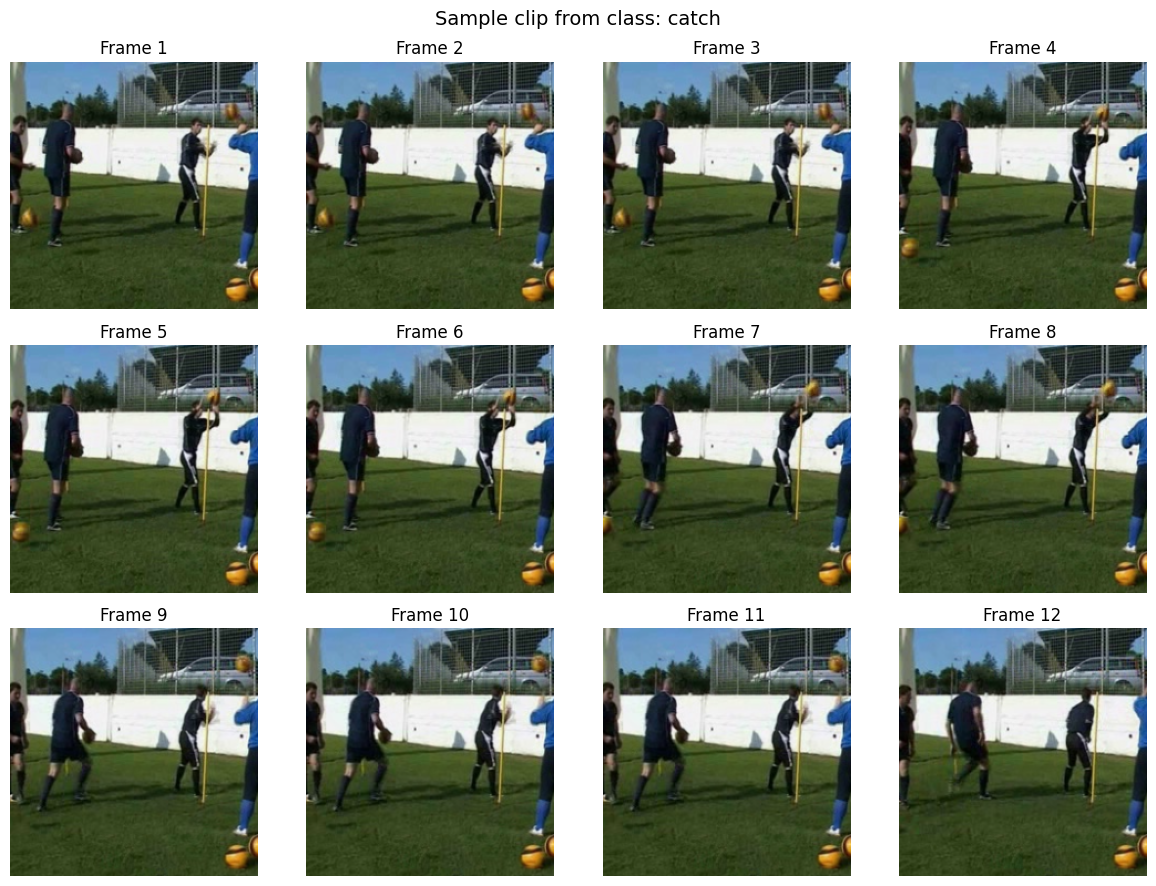

In [ ]:
sample_idx = 0
sample_frames, sample_label = train_dataset[sample_idx]
vis_frames = denormalize(sample_frames).cpu()
class_name = train_dataset.classes[sample_label]
frames_to_show = min(vis_frames.shape[0], 12)
cols = 4
rows = math.ceil(frames_to_show / cols)
plt.figure(figsize=(12, 3 * rows))
for i in range(frames_to_show):
    plt.subplot(rows, cols, i + 1)
    frame = vis_frames[i].permute(1, 2, 0).numpy()
    plt.imshow(frame)
    plt.axis('off')
    plt.title(f'Frame {i + 1}')
plt.suptitle(f'Sample clip from class: {class_name}', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
EPOCHS = 10
GRAD_ACCUM_STEPS = 16
BASE_LR = 5e-5
HEAD_LR = 2.5e-4
WEIGHT_DECAY = 0.05
PRETRAINED_NAME = 'vit_base_patch16_224'

weights_dir = './weights'
Path(weights_dir).mkdir(parents=True, exist_ok=True)
best_ckpt = Path(weights_dir) / 'lsvit_hmdb51_best.pt'
last_ckpt = Path(weights_dir) / 'lsvit_hmdb51_last.pt'

config = ViTConfig(image_size=IMG_SIZE)
model = LSViTForAction(config).to(DEVICE)
load_vit_checkpoint(model.backbone, PRETRAINED_NAME, weights_dir)

backbone_params = []
head_params = []
for name, param in model.named_parameters():
    if not param.requires_grad:
        continue
    if name.startswith("backbone"):
        backbone_params.append(param)
    else:
        head_params.append(param)

optimizer = torch.optim.AdamW(
    [
        {"params": backbone_params, "lr": BASE_LR},
        {"params": head_params, "lr": HEAD_LR},
    ],
    weight_decay=WEIGHT_DECAY,
)
scaler = torch.amp.GradScaler(enabled=torch.cuda.is_available())

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_acc = 0.0
for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(
        model,
        train_loader,
        optimizer,
        scaler,
        DEVICE,
        grad_accum_steps=GRAD_ACCUM_STEPS,
    )
    val_acc, val_loss = evaluate(model, val_loader, DEVICE)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    torch.save({'model': model.state_dict(), 'acc': val_acc}, last_ckpt)
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({'model': model.state_dict(), 'acc': best_acc}, best_ckpt)

    print(
        f'Epoch {epoch + 1}/{EPOCHS} | train_loss={train_loss:.4f} | train_acc={train_acc:.4f} | '
        f'val_loss={val_loss:.4f} | val_acc={val_acc:.4f} | best={best_acc:.4f}'
    )

trained_model = model
training_history = history

Loaded ViT weights from weights/vit_base_patch16_224_timm.pth
Missing keys: ['blocks.0.lmim.delta', 'blocks.0.lmim.reduce.weight', 'blocks.0.lmim.reduce.bias', 'blocks.0.lmim.expand.weight', 'blocks.0.lmim.expand.bias', 'blocks.0.lmim.temporal_mlp.0.weight', 'blocks.0.lmim.temporal_mlp.0.bias', 'blocks.0.lmim.temporal_mlp.1.weight', 'blocks.0.lmim.temporal_mlp.1.bias', 'blocks.0.lmim.temporal_mlp.3.weight', 'blocks.0.lmim.temporal_mlp.3.bias', 'blocks.1.lmim.delta', 'blocks.1.lmim.reduce.weight', 'blocks.1.lmim.reduce.bias', 'blocks.1.lmim.expand.weight', 'blocks.1.lmim.expand.bias', 'blocks.1.lmim.temporal_mlp.0.weight', 'blocks.1.lmim.temporal_mlp.0.bias', 'blocks.1.lmim.temporal_mlp.1.weight', 'blocks.1.lmim.temporal_mlp.1.bias', 'blocks.1.lmim.temporal_mlp.3.weight', 'blocks.1.lmim.temporal_mlp.3.bias', 'blocks.2.lmim.delta', 'blocks.2.lmim.reduce.weight', 'blocks.2.lmim.reduce.bias', 'blocks.2.lmim.expand.weight', 'blocks.2.lmim.expand.bias', 'blocks.2.lmim.temporal_mlp.0.weight',

Train:   0%|          | 0/1531 [00:00<?, ?it/s]

Val:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch 1/10 | train_loss=3.6463 | train_acc=0.0987 | val_loss=3.2694 | val_acc=0.2155 | best=0.2155


Train:   0%|          | 0/1531 [00:00<?, ?it/s]

Val:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch 2/10 | train_loss=2.1726 | train_acc=0.4079 | val_loss=2.2068 | val_acc=0.4543 | best=0.4543


Train:   0%|          | 0/1531 [00:00<?, ?it/s]

Val:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch 3/10 | train_loss=1.2354 | train_acc=0.6569 | val_loss=1.6953 | val_acc=0.5488 | best=0.5488


Train:   0%|          | 0/1531 [00:00<?, ?it/s]

Val:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch 4/10 | train_loss=0.8106 | train_acc=0.7618 | val_loss=1.4814 | val_acc=0.6062 | best=0.6062


Train:   0%|          | 0/1531 [00:00<?, ?it/s]

Val:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch 5/10 | train_loss=0.5705 | train_acc=0.8322 | val_loss=1.6928 | val_acc=0.5829 | best=0.6062


Train:   0%|          | 0/1531 [00:00<?, ?it/s]

Val:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch 6/10 | train_loss=0.4011 | train_acc=0.8860 | val_loss=1.6518 | val_acc=0.6341 | best=0.6341


Train:   0%|          | 0/1531 [00:00<?, ?it/s]

Val:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch 7/10 | train_loss=0.2737 | train_acc=0.9235 | val_loss=1.7486 | val_acc=0.6093 | best=0.6341


Train:   0%|          | 0/1531 [00:00<?, ?it/s]

Val:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch 8/10 | train_loss=0.2104 | train_acc=0.9391 | val_loss=1.7206 | val_acc=0.6388 | best=0.6388


Train:   0%|          | 0/1531 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7aaf869e9da0>
Traceback (most recent call last):
  File "/home/crl/Documents/anhthu/ros2_venv1/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/crl/Documents/anhthu/ros2_venv1/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7aaf869e9da0>
Traceback (most recent call last):
  File "/home/crl/Documents/anhthu/ros2_venv1/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/crl/Documents/anhthu/ros2_venv1/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert sel

Val:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch 9/10 | train_loss=0.1508 | train_acc=0.9587 | val_loss=2.0218 | val_acc=0.6155 | best=0.6388


Train:   0%|          | 0/1531 [00:00<?, ?it/s]

Val:   0%|          | 0/162 [00:00<?, ?it/s]

Epoch 10/10 | train_loss=0.1363 | train_acc=0.9600 | val_loss=1.9285 | val_acc=0.6357 | best=0.6388


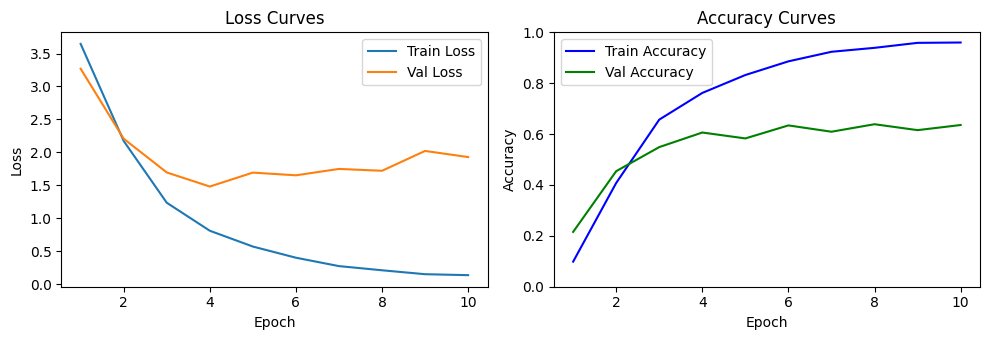

In [ ]:
epochs = range(1, len(training_history['train_loss']) + 1)
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))

axes[0].plot(epochs, training_history['train_loss'], label='Train Loss')
axes[0].plot(epochs, training_history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss Curves')
axes[0].legend()

axes[1].plot(epochs, training_history['train_acc'], label='Train Accuracy', color='blue')
axes[1].plot(epochs, training_history['val_acc'], label='Val Accuracy', color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy Curves')
axes[1].set_ylim(0, 1)
axes[1].legend()

plt.tight_layout()
plt.show()

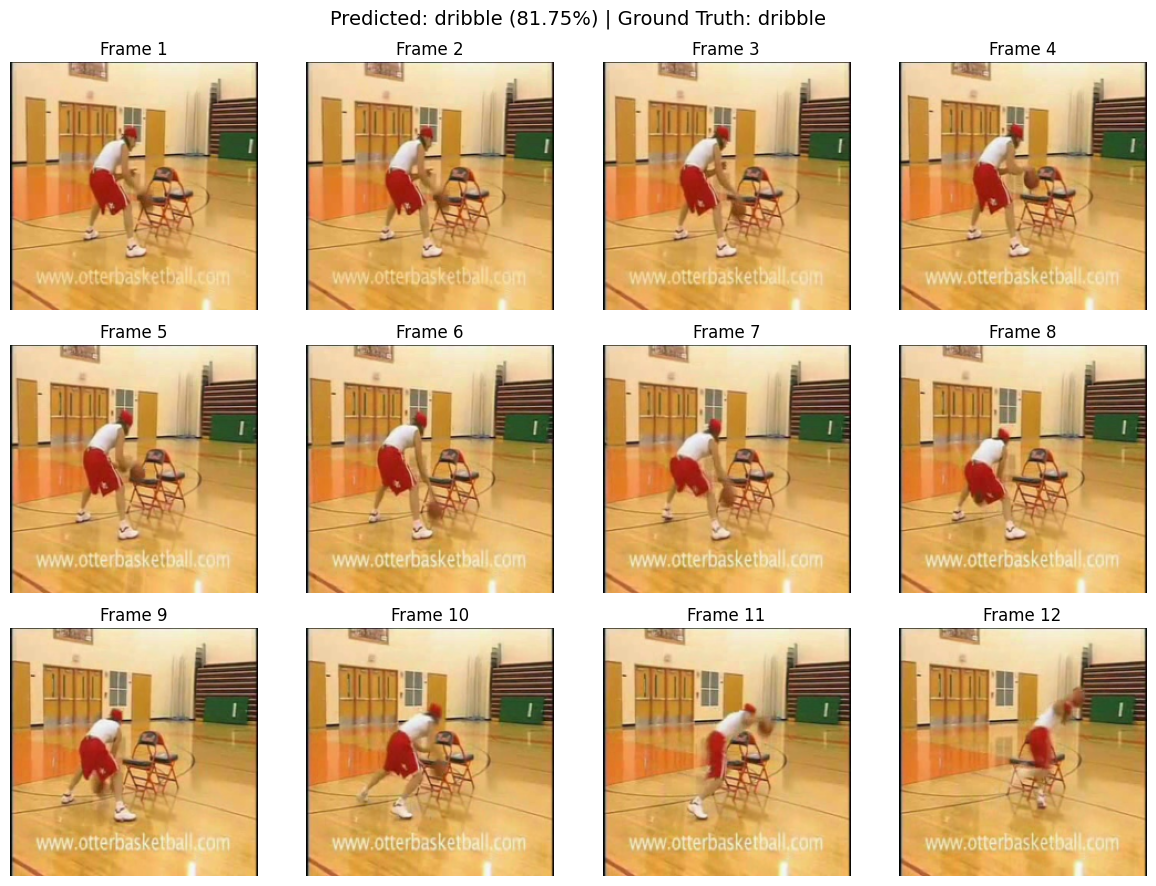

In [ ]:
trained_model.eval()
if best_ckpt.is_file():
    state = torch.load(best_ckpt, map_location=DEVICE)
    trained_model.load_state_dict(state['model'])

with torch.no_grad():
    sample_idx = random.randrange(len(val_dataset))
    sample_video, sample_label = val_dataset[sample_idx]
    logits = trained_model(sample_video.unsqueeze(0).to(DEVICE))
    probs = torch.softmax(logits, dim=1).cpu().squeeze(0)

pred_idx = int(probs.argmax())
pred_class = val_dataset.classes[pred_idx]
true_class = val_dataset.classes[sample_label]
confidence = float(probs[pred_idx])

vis_frames = denormalize(sample_video).cpu()
frames_to_show = min(vis_frames.shape[0], 12)
cols = 4
rows = math.ceil(frames_to_show / cols)
plt.figure(figsize=(12, 3 * rows))
for i in range(frames_to_show):
    plt.subplot(rows, cols, i + 1)
    frame = vis_frames[i].permute(1, 2, 0).numpy()
    plt.imshow(frame)
    plt.axis('off')
    plt.title(f'Frame {i + 1}')
plt.suptitle(
    f'Predicted: {pred_class} ({confidence:.2%}) | Ground Truth: {true_class}', fontsize=14
)
plt.tight_layout()
plt.show()